In [0]:
import os
import pandas as pd
from tqdm import tqdm_notebook
import scipy
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_roc_curve
import datetime
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier, plot_importance
from utils import featureEngineer, runLR, runXGB

In [0]:
train = pd.read_csv("./data/train.csv", index_col=0, low_memory=False)
test = pd.read_csv("./data/test.csv", index_col=0, low_memory=False)
submiss = pd.read_csv("./data/sample_submission.csv", low_memory=False)

## Feature engineer

In [0]:
%%time
data_full = featureEngineer(train, test, submiss)
data_full = data_full.drop(columns=['maCv'])

In [0]:
features_missing = [feature for feature in data_full.columns if any(data_full[feature].isnull())]

for col in features_missing:
    print(f'{col} has {data_full[col].isnull().sum()/len(data_full[col])} missing values')
    data_full[col + '_missing'] = data_full[col].isnull().astype('int')   

In [0]:
data_full = data_full.drop(columns=['label'])

cate_features = data_full.select_dtypes(include=['bool', 'object']).columns
num_features = data_full.select_dtypes(exclude=['bool', 'object']).columns

print(len(cate_features), len(num_features))

## One-hot encode (sparse matrix)

In [0]:
OH_encoded = pd.get_dummies(data_full, 
                            columns=data_full.columns, 
                            dummy_na=True,
                            drop_first=True,
                            sparse=True).sparse.to_coo()

In [0]:
imputer = SimpleImputer(strategy='mean')
retain_full  = pd.DataFrame(imputer.fit_transform(data_full[num_features]), 
                            columns=num_features)
retain_full = retain_full/retain_full.max()

encoded_full = scipy.sparse.hstack([OH_encoded, retain_full, retain_full**2]).tocsr()

encoded_train = encoded_full[:len(train)]
encoded_test = encoded_full[len(train):]

## Logistic Regression

In [0]:
submiss_dir='./submiss'

In [0]:
model = LogisticRegression(C=0.08, solver="lbfgs", max_iter=200)

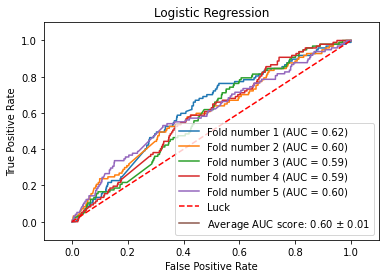

In [14]:
runLR(model=model,
      train_data=encoded_train, 
      labels=train.label, 
      test_data=encoded_test,
      index=test.index,
      n_folds=5,
      submiss_dir=submiss_dir)

In [0]:
param_grid = {'C' : np.logspace(-4, 4, 20), 'penalty' : ['l1', 'l2'], 'max_iter':[5000]}
clf = GridSearchCV(LogisticRegression(), scoring='roc_auc', param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
clf.fit(encoded_train, train.label)
print("Best hyper parameter settings ",clf.best_params_)
print("Best AUC CV :",clf.best_score_)

In [0]:
model = LogisticRegression(C=0.08858667904100823, solver="lbfgs", max_iter=200)
model.fit(encoded_train, train.label)
test_pred = model.predict_proba(encoded_test)[:,1]
submiss.label =  test_pred
submiss_path = os.path.join(submiss_dir , f'Logistic_Regression.csv')
submiss.to_csv(submiss_path, index=False)

## XGBoost

In [0]:
model = XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=5,
 scale_pos_weight=1,
 seed=27,
 eval_metric='auc',
 tree_method='gpu_hist',    # turn on GPU accelerator
 gpu_id=0)

CPU times: user 7.68 s, sys: 4.72 s, total: 12.4 s
Wall time: 13 s


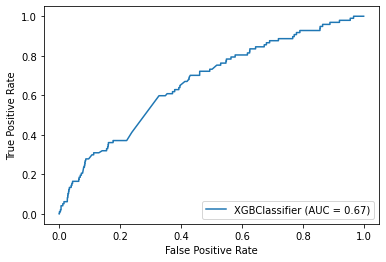

In [22]:
%%time
# best model sofar
X_train, X_valid, y_train, y_valid = train_test_split(encoded_train, train.label, test_size=0.2, random_state=42)

model.fit(X_train, y_train, 
             early_stopping_rounds=50, 
             eval_set=[(X_valid, y_valid)], 
             verbose=0)
plot_roc_curve(model, X_valid, y_valid)

In [0]:
fig,ax = plt.subplots(figsize=(15,10))
plot = plot_importance(model,ax,max_num_features=30, height=0.5)
plt.show()

In [0]:
thresholds = np.sort(list(set(model.feature_importances_)))[:10]

for threshold in tqdm_notebook(thresholds):
    selection = SelectFromModel(model, threshold=threshold, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_valid = selection.transform(X_valid)
    model.fit(select_X_train, y_train, 
             early_stopping_rounds=50, 
             eval_set=[(select_X_valid, y_valid)], 
             verbose=0)
    plot_roc_curve(model, select_X_valid, y_valid)
    plt.show()

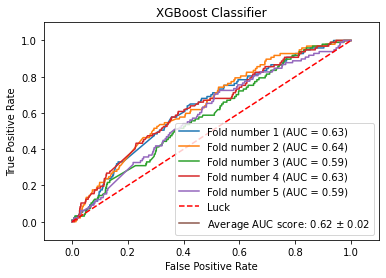

In [25]:
%%time
runXGB(model=model,
      train_data=encoded_train, 
      labels=train.label, 
      test_data=encoded_test,
      index=test.index,
      n_folds=5,
      submiss_dir='./submiss')